In [1]:
import numpy as np 
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [4]:
meta_data=pd.read_csv('C:/Users/prais/Downloads/ham10000_metadata_2024-06-04.csv')
meta_data

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_3692653,True,female
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_0959663,True,male
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,malignant,True,melanoma,histopathology,dermoscopic,IL_8194852,True,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11715,ISIC_0036060,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,NaN,NaN,NaN,False,pigmented benign keratosis,single image expert consensus,dermoscopic,IL_5218936,False,NaN
11716,ISIC_0036061,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,NaN,NaN,benign,False,nevus,single image expert consensus,dermoscopic,IL_5893216,True,NaN
11717,ISIC_0036062,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,70.0,head/neck,NaN,True,actinic keratosis,histopathology,dermoscopic,IL_9294619,False,female
11718,ISIC_0036063,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,NaN,NaN,NaN,False,pigmented benign keratosis,single image expert consensus,dermoscopic,IL_6088695,False,NaN


In [5]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB


In [6]:
unique_counts = meta_data.nunique()

print("\nUnique entries in each column:")
print(unique_counts)


Unique entries in each column:
isic_id                   11720
attribution                   1
copyright_license             1
age_approx                   17
anatom_site_general           6
benign_malignant              2
concomitant_biopsy            2
diagnosis                     8
diagnosis_confirm_type        4
image_type                    1
lesion_id                  8838
melanocytic                   2
sex                           2
dtype: int64


In [7]:
meta_data['sex'].unique()

array(['male', 'female', nan], dtype=object)

In [8]:
meta_data.describe(include='all')

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
count,11720,11720,11720,11337.000000,9503,9042,11720,11720,11720,11719,11720,11720,11377
unique,11720,1,1,NaN,6,2,2,8,4,1,8838,2,2
top,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,NaN,lower extremity,benign,True,nevus,histopathology,dermoscopic,IL_1795129,True,male
freq,1,11720,11720,NaN,2731,7737,6227,7737,6227,11719,6,9042,6179
mean,NaN,NaN,NaN,52.037135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,16.704833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(meta_data.isnull().sum())

isic_id                      0
attribution                  0
copyright_license            0
age_approx                 383
anatom_site_general       2217
benign_malignant          2678
concomitant_biopsy           0
diagnosis                    0
diagnosis_confirm_type       0
image_type                   1
lesion_id                    0
melanocytic                  0
sex                        343
dtype: int64


In [10]:
categorical_columns = ['diagnosis', 'diagnosis_confirm_type', 'anatom_site_general', 'benign_malignant']
numerical_columns = ['age_approx']

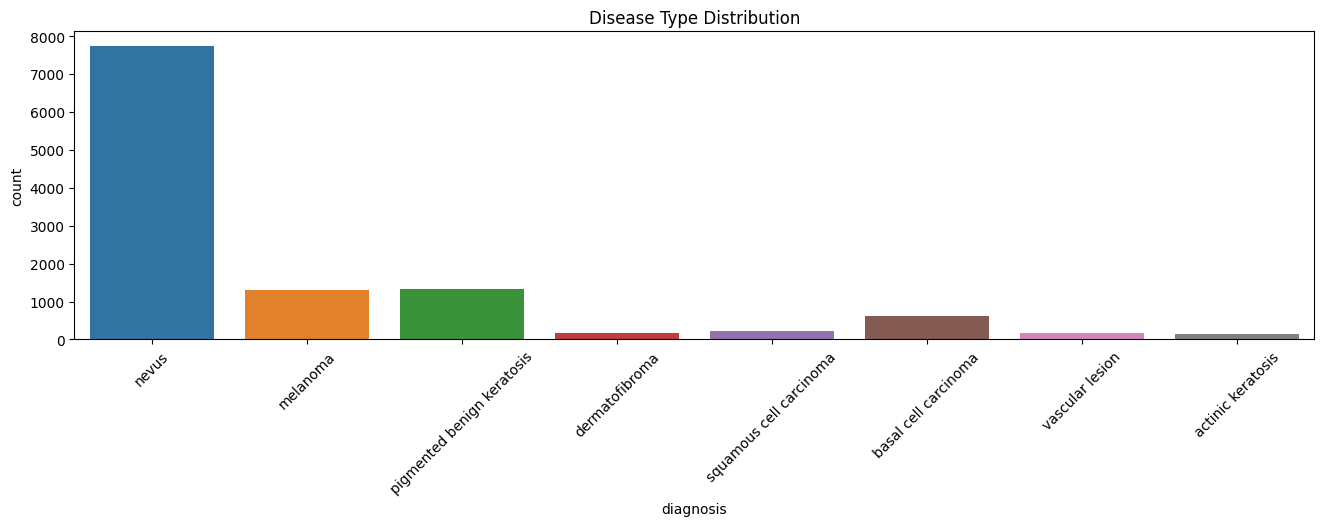

In [11]:
plt.figure(figsize=(16, 4))
sns.countplot(data=meta_data, x='diagnosis')
plt.title('Disease Type Distribution')
plt.xticks(rotation=45)
plt.show()

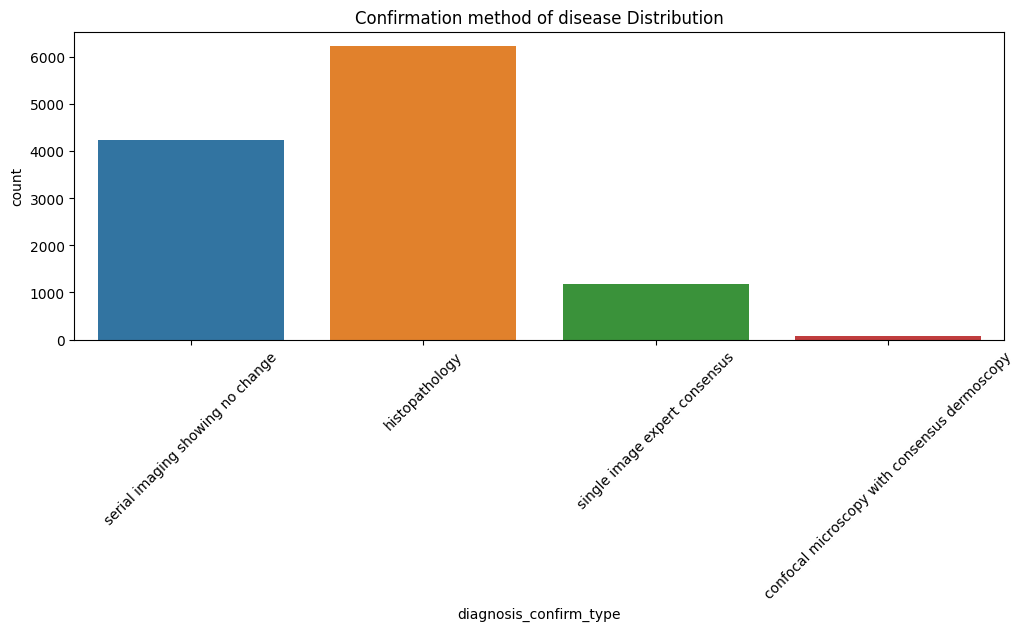

In [12]:
plt.figure(figsize=(12, 4))
sns.countplot(data=meta_data, x='diagnosis_confirm_type')
plt.title('Confirmation method of disease Distribution')
plt.xticks(rotation=45)
plt.show()

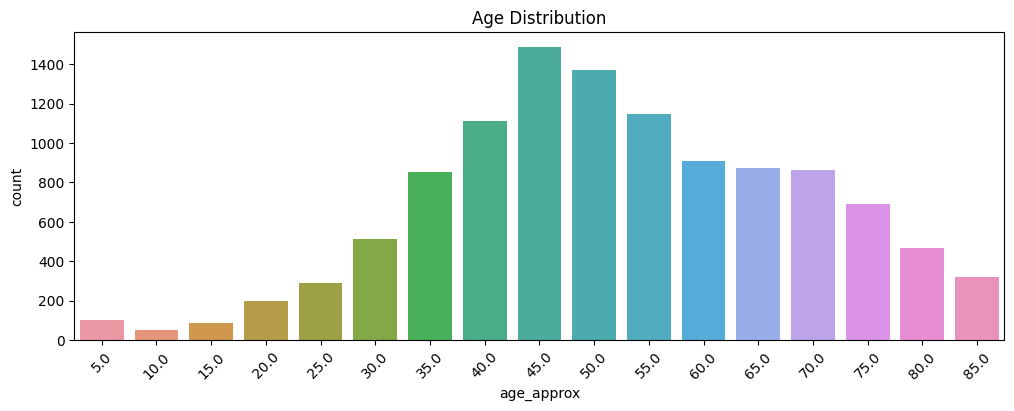

In [13]:
plt.figure(figsize=(12, 4))
sns.countplot(data=meta_data, x='age_approx')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()

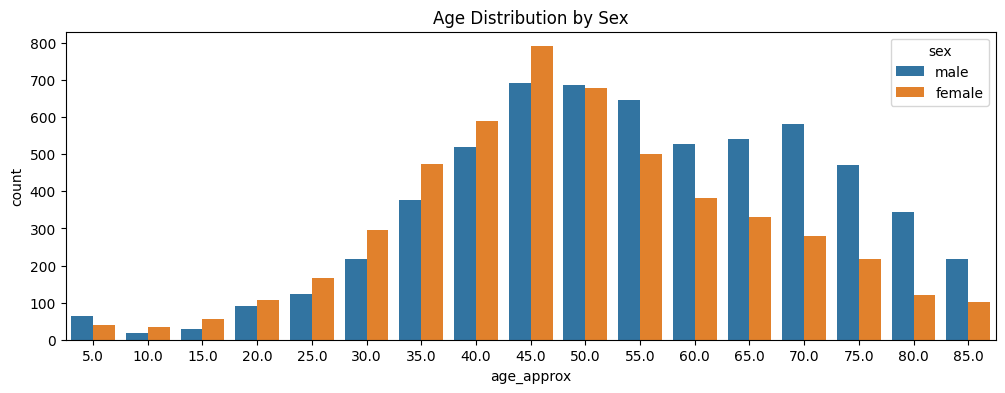

In [14]:
plt.figure(figsize=(12, 4))
sns.countplot(data=meta_data, x='age_approx', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

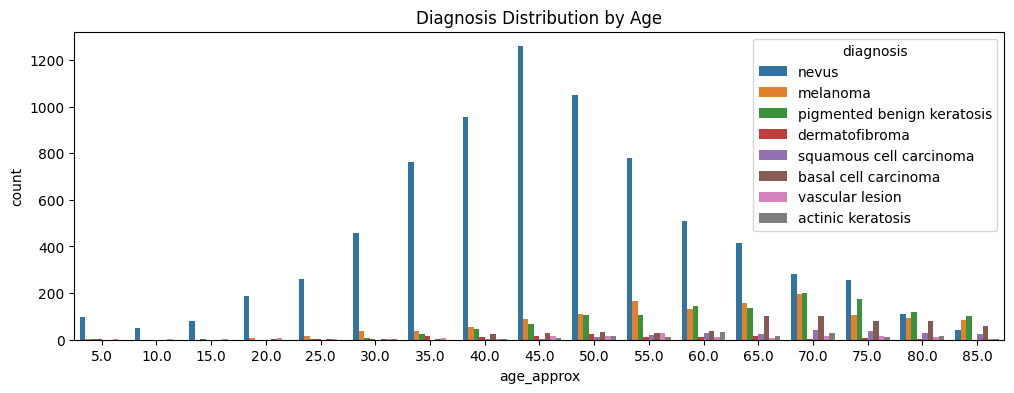

In [15]:
plt.figure(figsize=(12, 4))
sns.countplot(data=meta_data, x='age_approx', hue='diagnosis')
plt.title('Diagnosis Distribution by Age')
plt.show()

In [16]:
meta_data.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_3692653,True,female
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_0959663,True,male
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,malignant,True,melanoma,histopathology,dermoscopic,IL_8194852,True,male


In [17]:
meta_data['image_path'] = meta_data['isic_id'].apply(lambda x: os.path.join('C:/Users/prais/Downloads/ISIC-images', f"{x}.jpg").replace('\\', '/'))

In [18]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
meta_data['diagnosis_label'] = label_encoder.fit_transform(meta_data['diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'squamous cell carcinoma': 6, 'vascular lesion': 7}


In [19]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [20]:
# Separate features (X) and target variable (y)
X = meta_data.drop(columns=['diagnosis_label']) 
y = meta_data['diagnosis_label']

# Display the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (11720, 14)
Shape of target variable (y): (11720,)


In [21]:
X.head(5)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex,image_path
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male,C:/Users/prais/Downloads/ISIC-images/ISIC_0024...
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male,C:/Users/prais/Downloads/ISIC-images/ISIC_0024...
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_3692653,True,female,C:/Users/prais/Downloads/ISIC-images/ISIC_0024...
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,benign,False,nevus,serial imaging showing no change,dermoscopic,IL_0959663,True,male,C:/Users/prais/Downloads/ISIC-images/ISIC_0024...
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,malignant,True,melanoma,histopathology,dermoscopic,IL_8194852,True,male,C:/Users/prais/Downloads/ISIC-images/ISIC_0024...


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation and generators
train_datagen = ImageDataGenerator(
rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

Found 8204 validated image filenames belonging to 8 classes.
Found 3516 validated image filenames belonging to 8 classes.


In [24]:
from tensorflow.keras.applications import DenseNet121,InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

# Load DenseNet121 pre-trained on ImageNet without the top layer , pooling='avg
base_model =DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(7, activation='softmax')(x)

In [25]:
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
from keras.optimizers import Adam

# Specify the learning rate
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# Define callbacks
checkpoint = ModelCheckpoint(filepath='model_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [29]:
class_counts = meta_data['diagnosis_label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {i: total_samples/count for i, count in enumerate(class_counts.values())}

print("Class weights:", class_weights)

Class weights: {0: 1.5147990177071216, 1: 8.7593423019432, 2: 8.980842911877394, 3: 18.842443729903536, 4: 51.17903930131004, 5: 65.11111111111111, 6: 73.25, 7: 78.65771812080537}
